In [2]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# create dataframe with all filenames and Substrates

#meta_data = pd.read_csv("..\Data\Data_description.xlsx", encoding= 'latin', sep = ';')
meta_data = pd.read_excel("../Data/Data_description.xlsx")

substrate = 'Acetone_d6'
files_list = meta_data[['File', 'Substrate_name']]


In [4]:
def visualize_sum( filename:str, threshold = 0 ):
    data = pd.read_csv(f"../Data/{filename}")

    # sum up all spectra
    sum_spec = pd.DataFrame()
    sum_spec['chem_shift'] = data.iloc[:, 0] #data['Unnamed: 0']
    sum_spec['Intensity_sum']= data.iloc[:, 1:].sum(axis=1)

    # create linegraph
    plt.figure(figsize=(10, 6))
    sns.lineplot(sum_spec, x= 'chem_shift', y= 'Intensity_sum')

    # create vertical line for threshold
    plt.axhline(threshold, color="red", linewidth=0.5)


In [5]:
files_list.Substrate_name.unique()

array(['Acetone-d6', 'Fumarate-d2', 'Nicotinamide-d4',
       'Nicotinamide-d4+ pyruvate (500mM)',
       'Nicotinamide-d4+ pyruvate (400mM)',
       'Nicotinamide-d4+ pyruvate (300mM)',
       'Nicotinamide-d4+ pyruvate (200mM)',
       'Nicotinamide-d4+ pyruvate (100mM)',
       'Nicotinamide-d4+ pyruvate (50mM)',
       'Nicotinamide-d4+ pyruvate (10mM)', 'Pyruvate-d3 '], dtype=object)

<div class="alert alert-block alert-info">

When the spectra are visualized with a threshold, it becomes clear, that different values for the threshold are needed. Following function lets us visualize the spectra sorted by spectra

In [6]:

def substrate_spectra(substrate, threshold = 0):
    filtered_files = files_list[files_list['Substrate_name'] == substrate]['File']

    for filename in filtered_files:
        visualize_sum(filename, threshold)

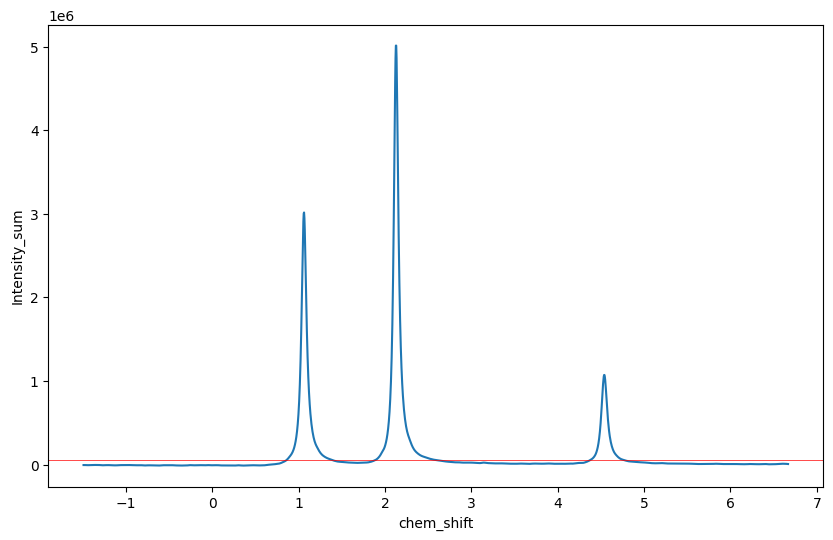

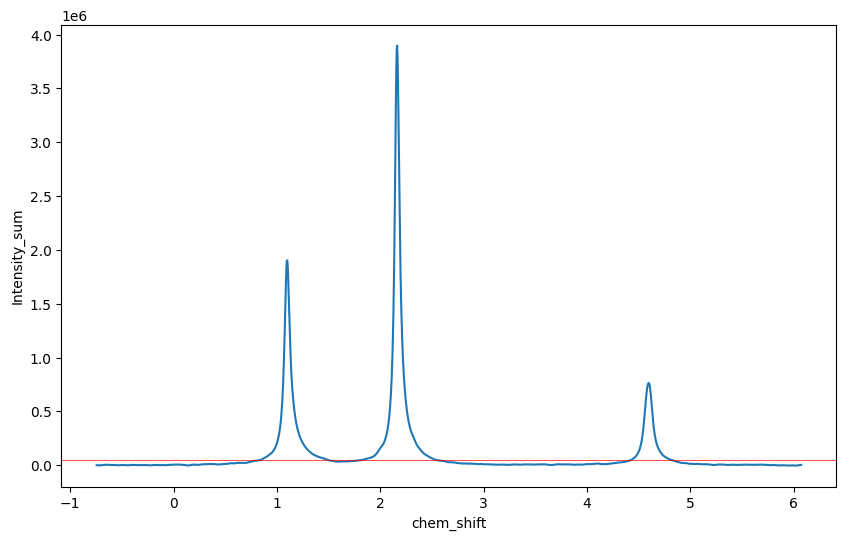

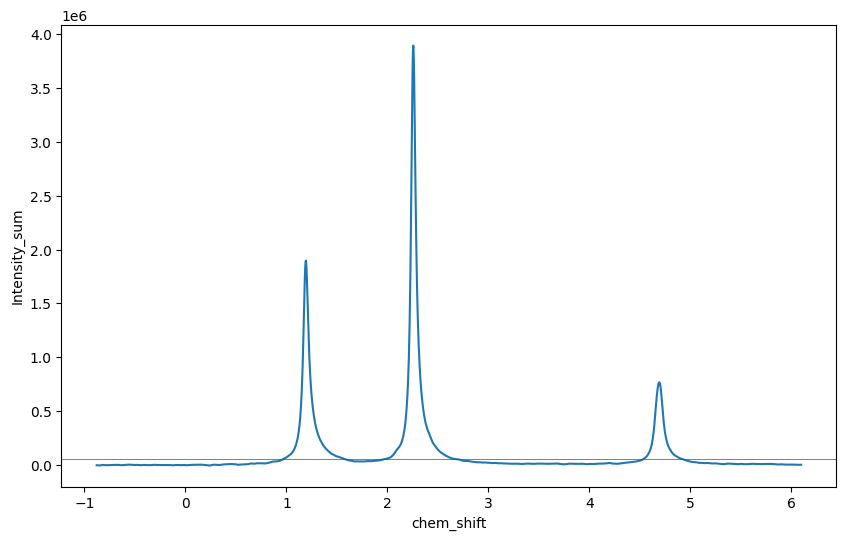

In [7]:
substrate_spectra('Acetone-d6',0.05e6 )

--- 

FileNotFoundError: [Errno 2] No such file or directory: '../Data/FA_20240715_2H_yeast_fumarate-d2_3.csv'

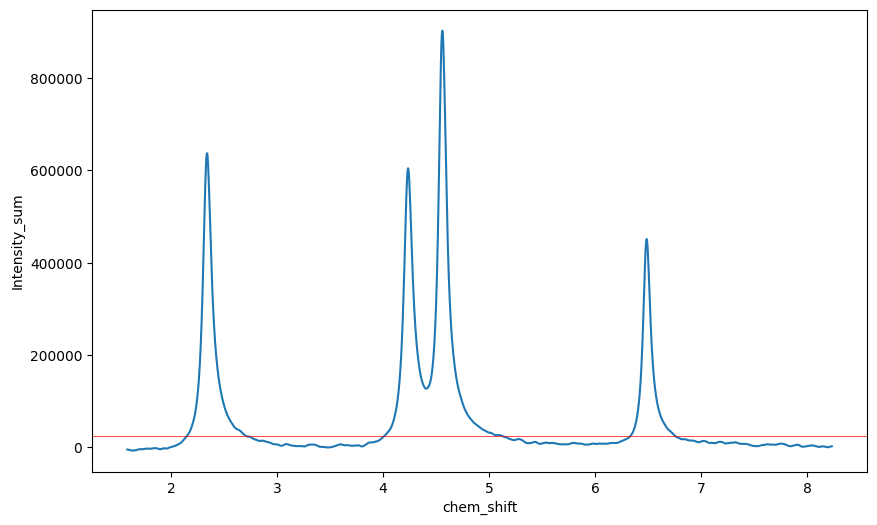

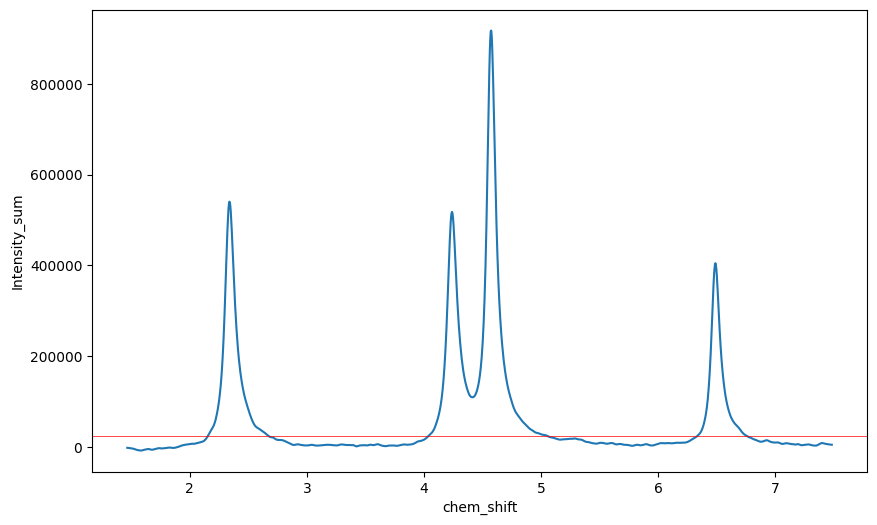

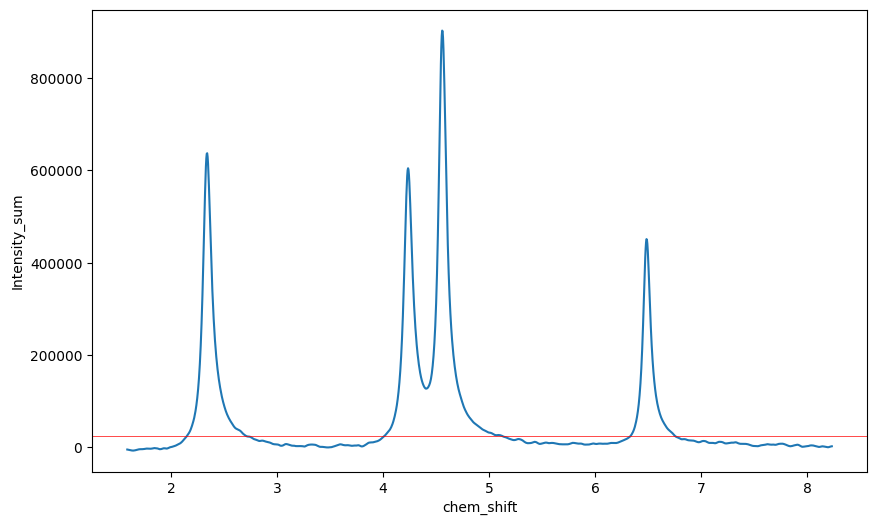

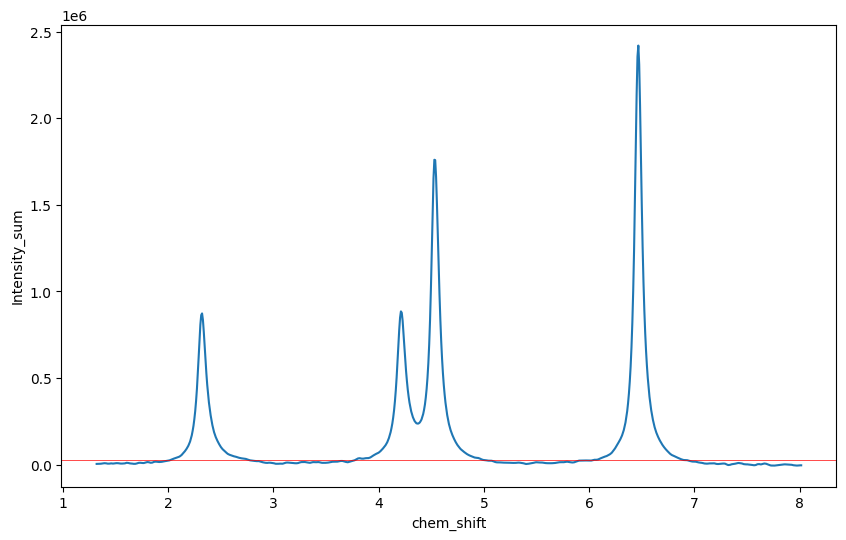

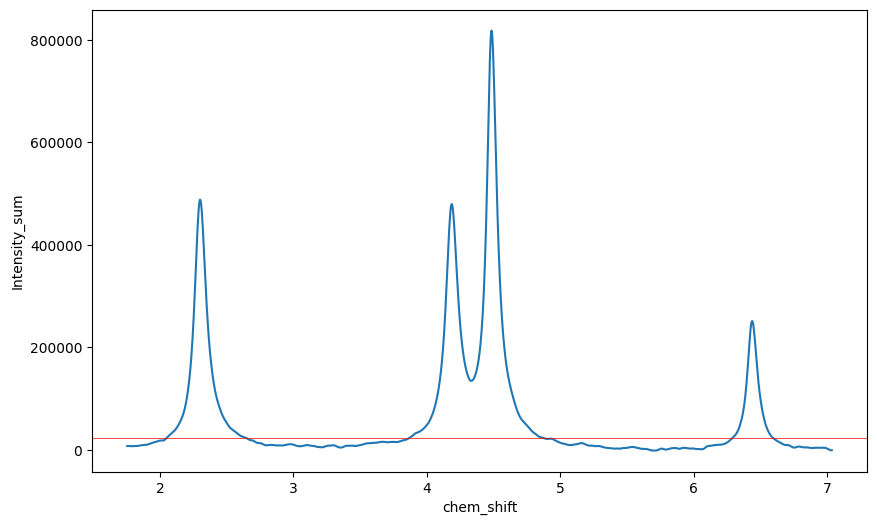

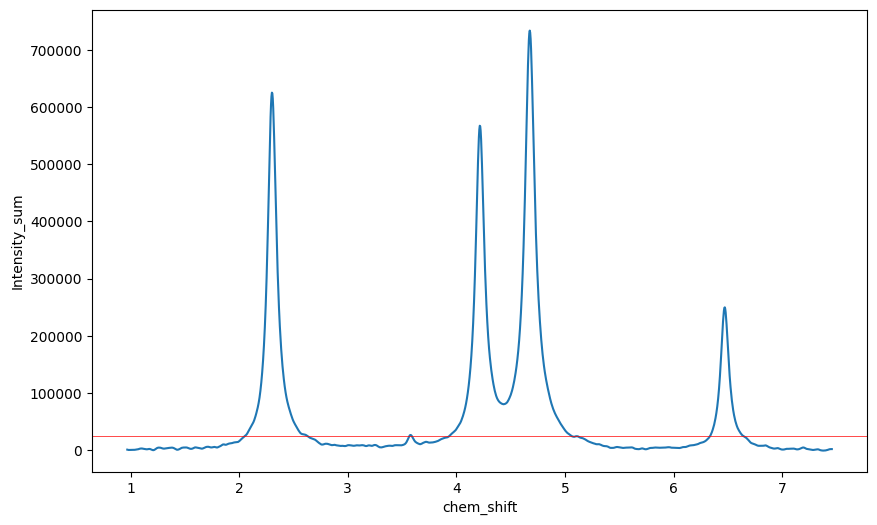

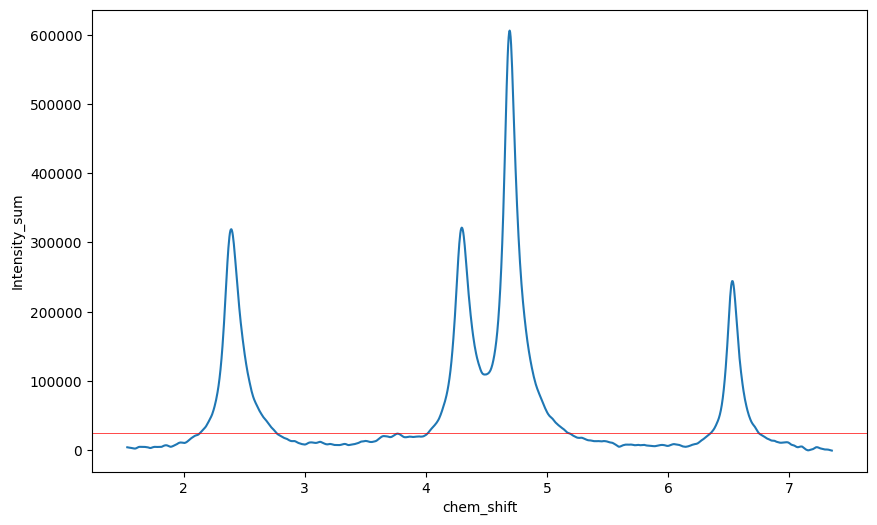

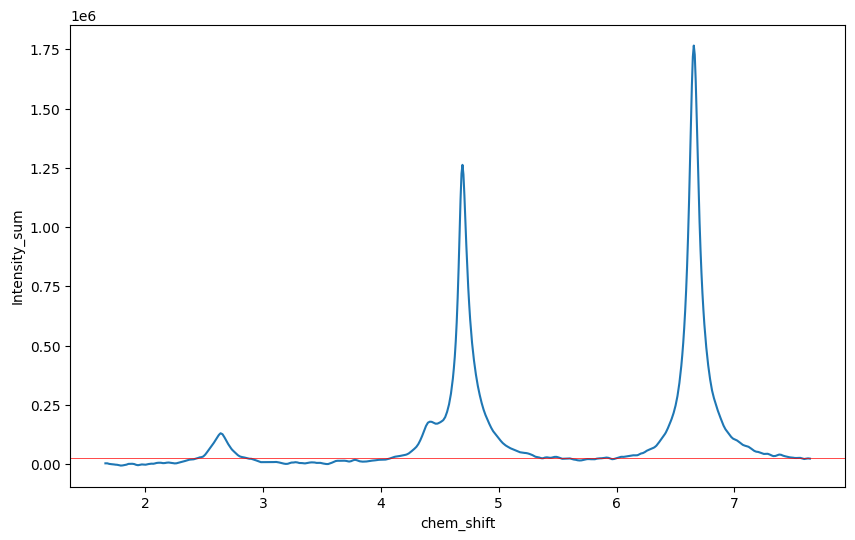

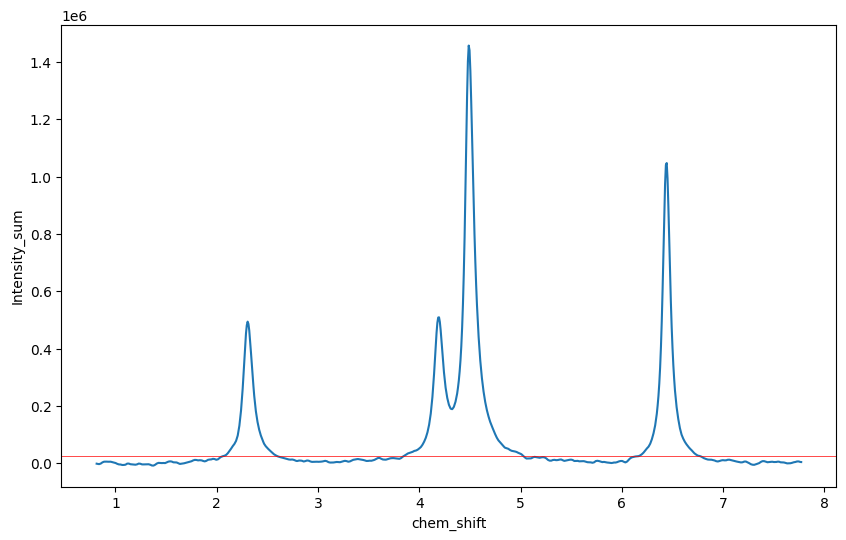

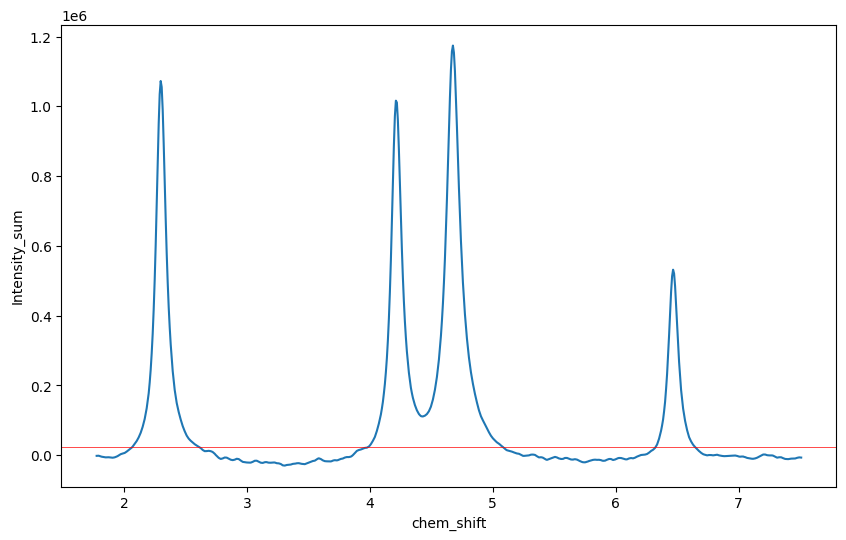

In [8]:
substrate_spectra('Fumarate-d2',0.024e6 )

<div class="alert alert-block alert-info">
Selected threshold does not work for every spectar no good threshold can be found --> where does the inconsistency come from?

In [8]:
#substrate_spectra('Nicotinamide-d4',0.05e6 )

#--> inconsistent threshold needed
# spectra are very variable

In [9]:
#substrate_spectra('Nicotinamide-d4+ pyruvate (500mM)',0.05e6 )

other Nicotinamide pyruvates not checked

In [10]:
#substrate_spectra('Pyruvate-d3 ',0.05e6 )

---

--> threshold for 'smoothing' is difficult to set, since some peaks are very low
--> different threshold for different substrate?

try:
calculate derivate
set all values where summed up spectra is below threshold to zero
calculate 
- calculate minima in 2nd derivative


# Fumarate d2 as example:

In [9]:
def visualize_sum( filename:str, threshold = 0 ):
    data = pd.read_csv(f"../Data/{filename}")

    # sum up all spectra
    sum_spec = pd.DataFrame()
    sum_spec['chem_shift'] = data.iloc[:, 0] #data['Unnamed: 0']
    sum_spec['Intensity_sum']= data.iloc[:, 1:].sum(axis=1)

    # create linegraph
    plt.figure(figsize=(10, 6))
    sns.lineplot(sum_spec, x= 'chem_shift', y= 'Intensity_sum')

    # create horizontal line for threshold
    plt.axhline(threshold, color="red", linewidth=0.5)


In [10]:
def peak( filename, threshold):
    # read specified file
    data = pd.read_csv(f"../Data/{filename}")

    #  sum of spectra
    sum_spec = pd.DataFrame()
    sum_spec['chem_shift'] = data.iloc[:, 0] 
    sum_spec['Intensity_sum']= data.iloc[:, 1:].sum(axis=1)
    
    #add derivatives to spectra
    sum_spec['1st derivative'] = np.gradient(sum_spec['Intensity_sum'], sum_spec['chem_shift'])
    sum_spec['2nd derivative'] = np.gradient(sum_spec['1st derivative'], sum_spec['chem_shift'])
    sum_spec['3rd derivative'] = np.gradient(sum_spec['2nd derivative'], sum_spec['chem_shift'])
    sum_spec['4th derivative'] = np.gradient(sum_spec['3rd derivative'], sum_spec['chem_shift'])

    sum_spec['sign_change'] = sum_spec['3rd derivative'].diff().lt(0) != sum_spec['3rd derivative'].shift().lt(0)

    # Filtere die Zeilen, in denen ein Vorzeichenwechsel festgestellt wurde
    peak_pos = sum_spec[(sum_spec['sign_change'])           #problem !!!
                                & (sum_spec['Intensity_sum'] > threshold) 
                                & (sum_spec['2nd derivative'] < 0)
                                & (sum_spec['4th derivative'] > 0)]['chem_shift'].tolist()

    #calculate; positions where sumofspectra above threshold, 2nd derivative below zero,  minima below zero -->  3rd derivative ==0 and 4th derivative >0
    # peak_pos = sum_spec[(sum_spec['Intensity_sum'] > threshold) 
    #                         & (sum_spec['3rd derivative'] == 0) # are not =0
    #                         & (sum_spec['2nd derivative'] < 0)
    #                         & (sum_spec['4th derivative'] > 0)]['chem_shift'].tolist()
    
    # visualize
    plt.figure(figsize=(10, 6))
    sns.lineplot(sum_spec, x= 'chem_shift', y= 'Intensity_sum')
    #plt.axvline(peak_pos, color = 'red', linewidth = 0.5)
    
    for pos in peak_pos:
        plt.axvline(pos, color='red', linewidth=0.5)#, linestyle='--')

    plt.show()

    return peak_pos

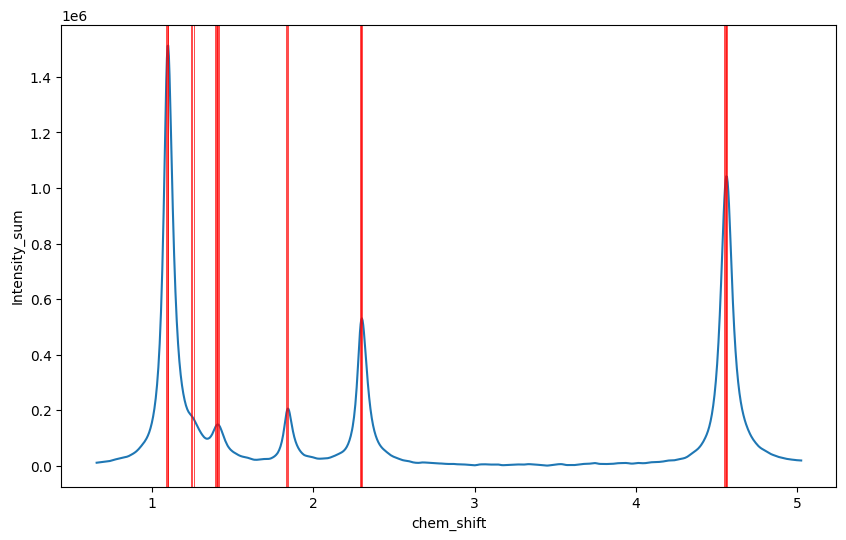

[1.08775,
 1.09182,
 1.09589,
 1.09997,
 1.24251,
 1.24658,
 1.2588,
 1.39319,
 1.39726,
 1.40133,
 1.40541,
 1.40948,
 1.41762,
 1.83302,
 1.83709,
 1.84117,
 2.28914,
 2.29322,
 2.29729,
 2.30136,
 4.54939,
 4.55347,
 4.55754,
 4.56161,
 4.56568]

In [11]:
peak_pos= peak( "../Data/FA_20240215_2H_yeast_Pyruvate-d3_5.csv", 0.1e6)
peak_pos

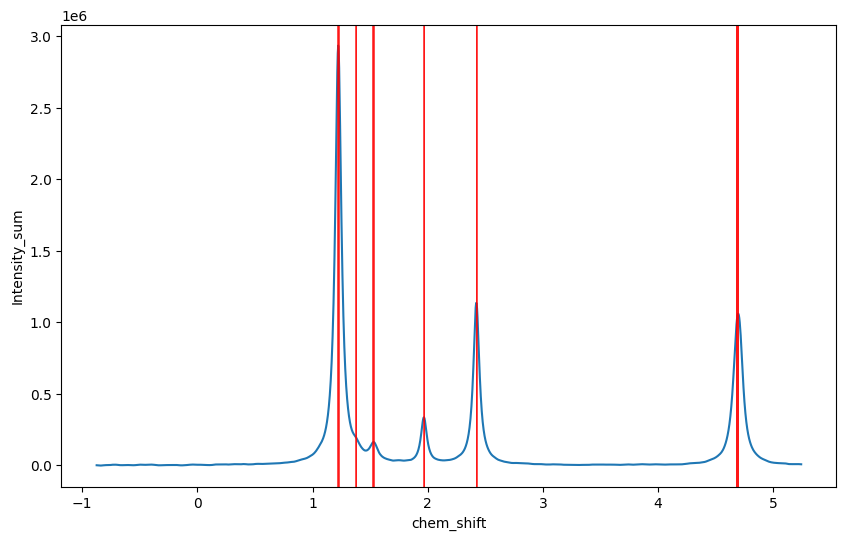

In [12]:
peak_pos= peak( 'FA_20231113_2H_yeast_Pyruvate-d3_1.csv', 0.1e6)


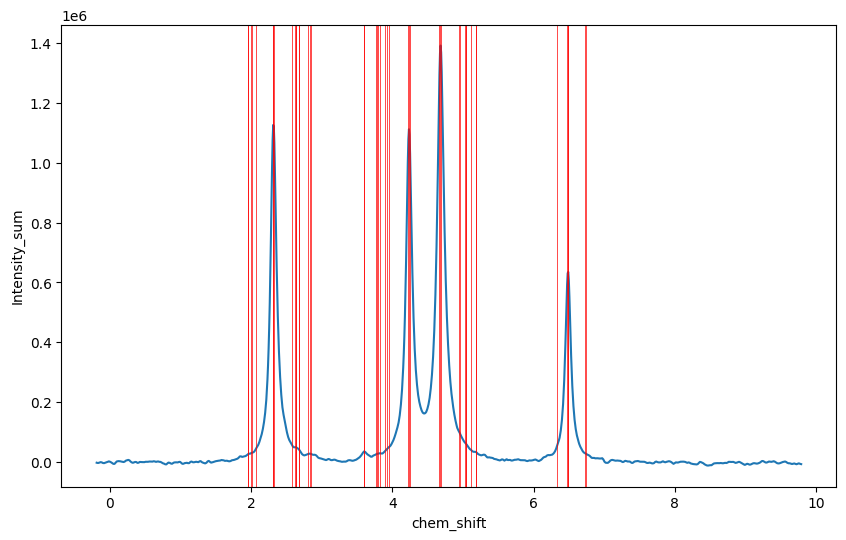

[1.9552,
 1.96334,
 2.00407,
 2.01221,
 2.06923,
 2.30543,
 2.31358,
 2.32172,
 2.57422,
 2.62309,
 2.63124,
 2.63938,
 2.67196,
 2.68011,
 2.80228,
 2.83486,
 2.84301,
 3.59235,
 3.6005,
 3.77154,
 3.77969,
 3.80412,
 3.82856,
 3.89372,
 3.9263,
 3.95073,
 4.22766,
 4.23581,
 4.24395,
 4.6675,
 4.67564,
 4.68379,
 4.94443,
 4.95257,
 5.03402,
 5.04217,
 5.05031,
 5.11547,
 5.18064,
 5.18878,
 6.33723,
 6.4757,
 6.48384,
 6.49199,
 6.72819,
 6.73634]

In [13]:
peak('FA_20240715_2H_yeast_Fumarate-d2_3_320.ser.csv', 0.025e6)

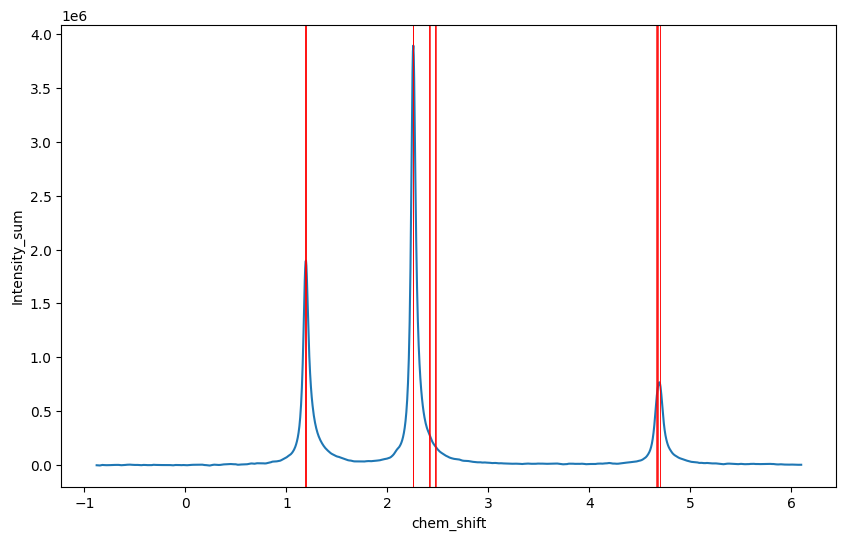

[1.18132,
 1.18539,
 1.18947,
 1.19354,
 2.24832,
 2.2524,
 2.25647,
 2.41122,
 2.4153,
 2.41937,
 2.46824,
 2.47231,
 2.47638,
 4.66333,
 4.6674,
 4.67147,
 4.67555,
 4.69591,
 4.69998]

In [14]:
peak('FA_20240206_2H_yeast_acetone-d6_3.csv', 0.15e6)


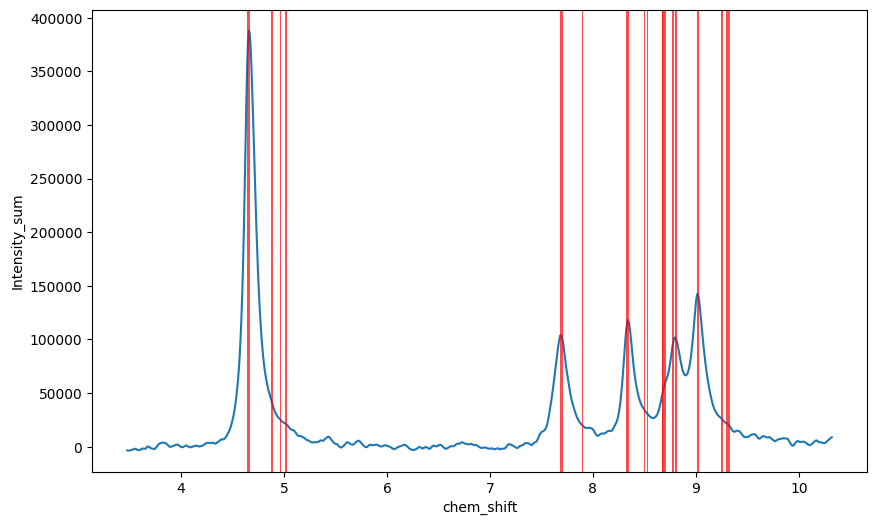

[4.643,
 4.65115,
 4.65929,
 4.87106,
 4.87921,
 4.96066,
 5.00953,
 5.01767,
 7.6811,
 7.68925,
 7.69739,
 7.89288,
 8.32456,
 8.33271,
 8.34085,
 8.49561,
 8.52819,
 8.66665,
 8.6748,
 8.68294,
 8.69109,
 8.69923,
 8.77254,
 8.78069,
 8.79698,
 8.80512,
 9.00875,
 9.01689,
 9.24495,
 9.2531,
 9.29382,
 9.30197,
 9.31011,
 9.31826]

In [16]:
peak('FA_20240108_2H_yeast_Nicotinamide-d4 _7.csv', 20000)